In [1]:
#%%capture
!pip install cellworld==0.0.105
!pip install tqdm
!pip install pandas
!pip install scipy
!pip install rtree
!pip install ipywidgets

In [2]:
from cellworld import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import rtree
from tqdm.notebook import tqdm
import matplotlib.path as mpath
import matplotlib.patches as mpatches
from scipy.spatial.distance import cdist
from ipywidgets import *
import pickle

In [3]:
def dist(p,q):
    """Return distance between two points."""
    return math.hypot(p[0]-q[0],p[1]-q[1])

def sparse_subset(points,r):
    """Return a maximal list of elements of points such that no pairs of
    points in the result have distance less than r."""
    result = []
    index = rtree.index.Index()
    for i, p in enumerate(points):
        px, py = p
        nearby = index.intersection((px - r, py - r, px + r, py + r))
        if all(dist(p, points[j]) >= r for j in nearby):
            result.append(p)
            index.insert(i, (px, py, px, py))
    return result

def get_visibility(e):
    """Gets world visibility from experiment object."""
    w = World.get_from_parameters_names('hexagonal','canonical',e.occlusions)
    occlusion_locations = w.cells.occluded_cells().get("location")
    occlusions_polygons = Polygon_list.get_polygons(occlusion_locations, w.configuration.cell_shape.sides, w.implementation.cell_transformation.size / 2, w.implementation.space.transformation.rotation + w.implementation.cell_transformation.rotation) # ploygon object
    vis = Location_visibility(occlusions_polygons)
    return vis,w

def get_vertices(e):
    """Gets unique vertices from all polygons."""
    # make a list of all polygon vertices
    w = World.get_from_parameters_names('hexagonal','canonical',e.occlusions)
    all_polygons = Polygon_list.get_polygons(w.cells.get('location'),w.configuration.cell_shape.sides, w.implementation.cell_transformation.size / 2, w.implementation.space.transformation.rotation + w.implementation.cell_transformation.rotation)
    x = []
    y = []
    for poly in all_polygons:
        x.append(poly.vertices.get('x'))
        y.append(poly.vertices.get('y'))
    x = np.hstack(x).reshape(1,-1).T
    y = np.hstack(y).reshape(1,-1).T
    verts = np.concatenate((x,y),axis=1)
    pts = verts.tolist()

    # get unique vertices, removing those closeby
    sparse_pts = sparse_subset(pts,0.01)
    sparse_arr = np.vstack(sparse_pts)
    return sparse_arr

def get_tiles(n,e):
    """Get nxn locations tiled across the world in experiment object, then removes tiles
    that are within obstacles in the world. (needs to Display the world to do so)"""
    # generate world tiles
    w = World.get_from_parameters_names('hexagonal','canonical',e.occlusions)
    x = np.linspace(0,1,n)
    xv,yv = np.meshgrid(x,x,indexing='ij')
    xv = xv.reshape(1,-1)
    yv = yv.reshape(1,-1)
    points = np.concatenate((xv,yv)).T
    
    # get the wall limits
    d = Display(w, fig_size=(1,1), padding=0, cell_edge_color="lightgrey")
    path = d.habitat_polygon.get_path()
    transform = d.habitat_polygon.get_patch_transform()
    newpath = transform.transform_path(path)
    polygon = mpatches.PathPatch(newpath)
    inside = []
    inside.append(~newpath.contains_points(points))

    # get the occlusion limits and remove points
    for poly in d.cell_polygons:
        if poly._facecolor[0]==0:
            path = poly.get_path()
            transform = poly.get_patch_transform()
            newpath = transform.transform_path(path)
            polygon = mpatches.PathPatch(newpath)
            inside.append(newpath.contains_points(points,radius=0.025))
    index = np.any(np.vstack(inside).T,axis=1)
    return points[~index,:]

def plot_tiles(pts,sparse_arr,e):
    a = 1
    w = World.get_from_parameters_names('hexagonal','canonical',e.occlusions)
    
    # display
    fig,ax = plt.subplots(1,2,figsize=(10,5))
    d = Display(w, fig_size=(5,5), padding=0, cell_edge_color="lightgrey",ax=ax[0])
    ax[0].scatter(pts[:,0],pts[:,1],5,'g',alpha = a)
    ax[0].scatter(sparse_arr[:,0],sparse_arr[:,1],20,'m')

    Display(w, fig_size=(5,5), padding=0, cell_edge_color="lightgrey",ax=ax[1])
    ax[1].scatter(pts[:,0],pts[:,1],5,'g',alpha = a)
    ax[1].scatter(sparse_arr[:,0],sparse_arr[:,1],20,'m')
    ax[1].set_xlim((.25,.3))
    ax[1].set_ylim((.25,.3))
    return [fig,ax]

def compute_visibility(src,dst,vis):
    """returns a visibility graph (V) and angle graph (A) between every point in
    src and dst according to visibility object vis"""
    m = len(src)
    p = len(dst)
    V = np.empty((m,p))
    A = np.empty((m,p))
    for i in tqdm(range(m)):
        loci = Location(src[i,0],src[i,1])
        for j in range(p):
            locj = Location(dst[j,0],dst[j,1])
            V[i,j] = vis.is_visible(loci,locj)
            A[i,j] = to_degrees(loci.atan(locj))
    return V,A

## Load and Preprocess

[<Figure size 720x360 with 2 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)]

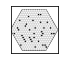

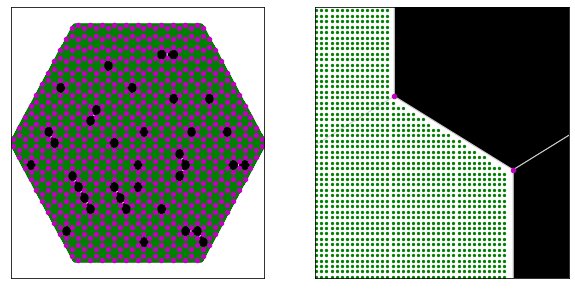

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

In [4]:
e = Experiment.load_from_file('./MICE_20220608_1557_DMM3_21_05_SR5_experiment.json')
vis,w = get_visibility(e)
sparse_arr = get_vertices(e)
n = 1000
pts = get_tiles(n,e)
plot_tiles(pts,sparse_arr,e)

## Compute visibility graph
Between tile locations and vertices

In [6]:
filename = f'visibility-{e.occlusions}-{n}.pkl'
filepath = f'./{filename}'

if not glob.glob(filepath):
    print(f'Computing visibility graph using {n}x{n} resolution...')
    V,A = compute_visibility(pts,sparse_arr,vis)
    print(f'Saving visibility graph {filename}...')
    pickle.dump([A,V,pts,sparse_arr],open(filepath,'wb'))
    
else:
    print(f'Loading visibility graph {filename}...')
    [A,V,pts,sparse_arr] = pickle.load(open(filepath,'rb'))
    
vis_graph = {'V':V,'A':A,'src':pts,'dst':sparse_arr}

Loading visibility graph visibility-21_05-1000.pkl...


## Test ITOR
1. plot tiles
2. simulate head and tail pose
3. get nearest tile points

First define some functions:

In [7]:
def get_closest_tile(loc,vis_graph):
    """Get closest tile location to given location."""
    idx = cdist(loc.reshape(1,-1),vis_graph['src']).argmin()
    return vis_graph['src'][idx,:],idx

def get_fov_points(head_pt,head_angle,vis_graph,fov = np.rad2deg(1.74533)):
    """Get tiles within the FOV."""
    _,idx = get_closest_tile(head_pt,vis_graph)
    tA = np.deg2rad(vis_graph['A'][idx,:])
    sA = np.deg2rad(head_angle)
    a = np.min(np.concatenate(((2 * np.pi) - np.abs(tA - sA).reshape(-1,1),
                               np.abs(tA - sA).reshape(-1,1)),axis=1),axis=1)
    return (np.abs(np.rad2deg(a)) < fov)

def get_visibility(loc,vis_graph):
    """Returns which points are visible from the provided location"""
    pt,idx = get_closest_tile(loc,vis_graph)
    return (vis_graph['V'][idx,:]==1),pt
    

def compute_itor(pose,head_angle,vis_graph,head_parts=['head_base'],body_parts=['body_mid'],fov = np.rad2deg(1.74533)):
    """Returns ITOR value and various visible points in the environment based on
    pose, head angle, FOV"""
    # get closest tiles for each part:
    v = []
    ppoints = []
    for p in pose:
        vis,pt = get_visibility(np.array(pose[p]),vis_graph)
        v.append(vis)
        ppoints.append(pt)
    v = np.vstack(v)
    ppoints = np.vstack(ppoints)
    
    # get head and body parts
    head_ind = [i for i in range(len(list(pose.keys()))) if list(pose.keys())[i] in head_parts]
    body_ind = [i for i in range(len(list(pose.keys()))) if list(pose.keys())[i] in body_parts]
    
    # get points in the FOV
    fov_verts = get_fov_points(ppoints[head_ind,:],head_angle,vis_graph,fov)
    
    # which vertices that are visible to the head:
    vis_verts = np.any(v[head_ind,:],axis=0) & fov_verts
    
    # of FOV visible vertices, which ones are visible to the body:
    body_verts = np.any(v[body_ind,:],axis=0) & vis_verts
    
    # compute ITOR as 1-(visible_to_body/visible_to_head)
    ITOR = 1 - np.sum(body_verts)/np.sum(vis_verts)
    
    return {'ITOR':ITOR, 
            'vis_omni': np.any(v[head_ind,:],axis=0),
            'vis_head': vis_verts,
            'vis_body': body_verts,
            'head_parts': head_parts,
            'head_idx': head_ind,
            'body_parts': body_parts,
            'body_idx': body_ind,
            'pose_points': ppoints,
            'head_angle': head_angle}

    
    
    

# ITOR SIMULATOR

310.0


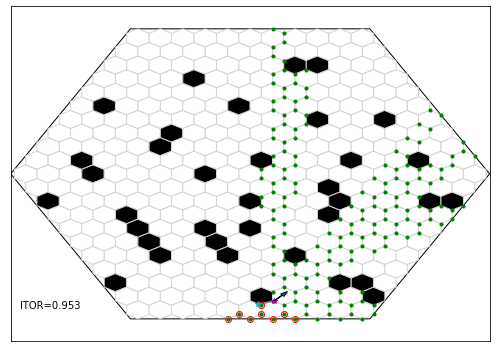

In [8]:
def plot_itor(I,vis_graph,w,ax,fig):
    # plot the world
    d = Display(w, fig_size=(7,9), padding=0, cell_edge_color="lightgrey",ax=ax,fig=fig)
    # plot the pose used to compute ITOR
    ppts = np.vstack(I['pose_points'])
    h0 = ax.arrow(ppts[I['head_idx'],0][0],ppts[I['head_idx'],1][0],
                  np.cos(np.deg2rad(90-I['head_angle']))*.025,
                  np.sin(np.deg2rad(90-I['head_angle']))*.025,head_width=.01,zorder=4)
    h1, = ax.plot(ppts[:,0],ppts[:,1],'grey',marker='.')
    h2, = ax.plot(ppts[I['head_idx'],0],
                  ppts[I['head_idx'],1],'m',marker='*',zorder=3)
    h3, = ax.plot(ppts[I['body_idx'],0],
                  ppts[I['body_idx'],1],'c',marker='*',zorder=3)
    h4, = ax.plot(vis_graph['dst'][I['vis_omni'],0],
                  vis_graph['dst'][I['vis_omni'],1],'g.',alpha=0.25)
    h5, = ax.plot(vis_graph['dst'][I['vis_head'],0],
                  vis_graph['dst'][I['vis_head'],1],'g.')
    h6, = ax.plot(vis_graph['dst'][I['vis_body'],0],
                  vis_graph['dst'][I['vis_body'],1],'ro',fillstyle='none')
    h7 = ax.text(0.02,0.1,f'ITOR={np.round(I["ITOR"],3)}')
    
    return h0,h1,h2,h3,h4,h5,h6,h7

def update_plot_itor(I,vis_graph):
    # get pose
    ppts = np.vstack(I['pose_points'])
    # plot
    global h0
    h0.remove()
    h0 = ax.arrow(ppts[I['head_idx'],0][0],ppts[I['head_idx'],1][0],
                  np.cos(np.deg2rad(90-I['head_angle']))*.025,
                  np.sin(np.deg2rad(90-I['head_angle']))*.025,head_width=.01,zorder=4)
    h1.set_xdata(ppts[:,0])
    h1.set_ydata(ppts[:,1])
    h2.set_xdata(ppts[I['head_idx'],0])
    h2.set_ydata(ppts[I['head_idx'],1])
    h3.set_xdata(ppts[I['body_idx'],0])
    h3.set_ydata(ppts[I['body_idx'],1])
    h4.set_xdata(vis_graph['dst'][I['vis_omni'],0])
    h4.set_ydata(vis_graph['dst'][I['vis_omni'],1])
    h5.set_xdata(vis_graph['dst'][I['vis_head'],0])
    h5.set_ydata(vis_graph['dst'][I['vis_head'],1])
    h6.set_xdata(vis_graph['dst'][I['vis_body'],0])
    h6.set_ydata(vis_graph['dst'][I['vis_body'],1])
    h7.set_text(f'ITOR={np.round(I["ITOR"],3)}')
    fig.canvas.draw()
    fig.canvas.draw_idle()
                      
def update_sim_pose(head_x=0.55,head_y=0.12,body_angle=180,head_angle=45,fov=np.rad2deg(1.74533)):
    pose = {'head_base':[head_x,head_y],
            'body_mid':[head_x+np.cos(np.deg2rad(body_angle))*0.03,
                        head_y+np.sin(np.deg2rad(body_angle))*0.03]}
    return pose,head_angle,fov
                      
    

# body update
# fov=np.rad2deg(1.74533)
fov = 310.0
pose,head_angle,fov = update_sim_pose(fov=fov)
print(fov)

# compute ITOR
I = compute_itor(pose,head_angle,vis_graph,fov=fov)

# plot
fig,ax = plt.subplots(1,1,figsize=(7,5))
h0,h1,h2,h3,h4,h5,h6,h7 = plot_itor(I,vis_graph,w,ax,fig)

<IPython.core.display.Javascript object>


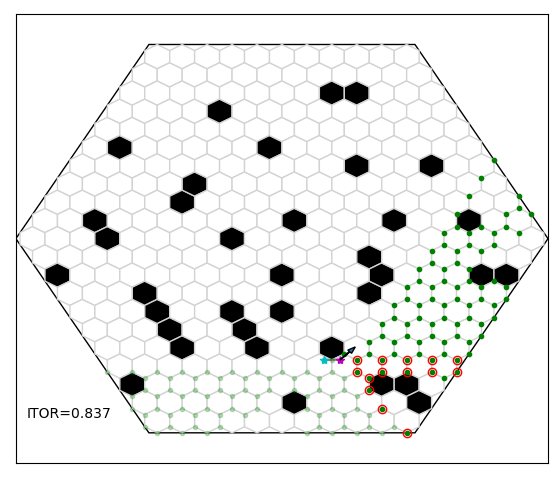

interactive(children=(IntSlider(value=45, description='head_angle', max=180, min=-180), IntSlider(value=180, d…

In [9]:
%matplotlib notebook

def update_sim(head_angle = 45, body_angle=180, head_x = 0.55, head_y = 0.12, fov = 310.0/2):
    # body update
    pose,head_angle,_ = update_sim_pose(head_x,head_y,body_angle,head_angle)

    # compute ITOR
    I = compute_itor(pose,head_angle,vis_graph,fov=fov)
    
    # update the plot
    update_plot_itor(I,vis_graph)

# settings
full_fov = np.rad2deg(1.74533)
binocular_fov = np.rad2deg(0.349066)

# body update
pose,head_angle,fov = update_sim_pose(fov = 310.0/2)

# compute ITOR
I = compute_itor(pose,head_angle,vis_graph,fov=fov)

# plot
fig,ax = plt.subplots(1,1,figsize=(7,5))
h0,h1,h2,h3,h4,h5,h6,h7 = plot_itor(I,vis_graph,w,ax,fig)


interact(update_sim,head_angle=widgets.IntSlider(min=-180, max=180, step=1, value=45),
        body_angle=widgets.IntSlider(min=0, max=360, step=1, value=180),
        head_x=widgets.FloatSlider(min=0, max=1, step=0.01, value=0.55),
        head_y=widgets.FloatSlider(min=0, max=1, step=0.01, value=0.12),
        fov=widgets.RadioButtons(options=[np.rad2deg(1.74533)+50,np.rad2deg(1.74533),np.rad2deg(0.349066)],description='FOV',disabled=False));


In [303]:
np.rad2deg(0.349066)

20.000008571513593

# POSE STATISTICS

We want to know:
1. What is the typical head-nose distance
2. Given a head direction, what are the limits of various body parts (rotate by head direction and look at distributions of other parts)

In [312]:
%matplotlib inline
# functions to extract pose data
class PoseList(JsonList):
  def __init__(self):
    super().__init__(list_type=PosePart)

class PosePart(JsonObject):
  def __init__(self):
    self.part = str()
    self.location = Location()
    self.camera = int()
    self.score = float()
    
def rotate(p, origin=(0, 0), degrees=0):
    angle = np.deg2rad(degrees)
    R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle),  np.cos(angle)]])
    o = np.atleast_2d(origin)
    p = np.atleast_2d(p)
    return np.squeeze((R @ (p.T-o.T) + o.T).T)

def get_pose(step):
    p = PoseList.parse(step.data)
    pose = {}
    for i in range(len(p)):
        pose.update({p[i].part:[p[i].location.x,p[i].location.y]})
    return pose
        

# poselist = PoseList.parse(t.get('data'))
# poselist[0].part
# poselist[0].location
# score threshold probably use .8

## Visualization

- plot pose distributions conditioned on head direction and position
- compute distribution of head lengths

In [282]:
# extract pose from data
POSEx = []
POSEy = []
SCORE = []
for ep in e.episodes:
    pt = ep.trajectories.where('agent_name','prey').get_unique_steps()
    for step in pt:
        posex = []
        posey = []
        score = []
        if step.data:
            pose = PoseList.parse(step.data)
            for i in range(len(pose)):
                posex.append(pose[i].location.x)
                posey.append(pose[i].location.y)
                score.append(pose[i].score)
            POSEx.append(posex)
            POSEy.append(posey)
            SCORE.append(score)
poseX = np.vstack(POSEx)
poseY = np.vstack(POSEy)
score = np.vstack(SCORE)

# remove bad scores
poseX[score < 0.8] = np.nan
poseY[score < 0.8] = np.nan

In [298]:
parts = ['body_mid','head_base','nose','tail_base','tail_post_base','tail_pre_tip','tail_tip']
order = np.array((6,5,4,3,0,1,2))
print(parts)

# parts to use for position and angle norms
norm_part = 'head_base'
rot_parts = [norm_part, 'nose'] #[norm_part,'body_mid']

['body_mid', 'head_base', 'nose', 'tail_base', 'tail_post_base', 'tail_pre_tip', 'tail_tip']


In [299]:
# normalize position
normI = parts.index(norm_part)
px_norm = poseX[:,:] - poseX[:,normI].reshape(-1,1)
py_norm = poseY[:,:] - poseY[:,normI].reshape(-1,1)
#_ = plt.plot(px_norm.T,py_norm.T)

# rotate
rotI = [parts.index(x) for i,x in enumerate(rot_parts)]
angle = np.rad2deg(np.arctan2(
    [py_norm[:,rotI[0]],py_norm[:,rotI[1]]],
    [px_norm[:,rotI[0]],px_norm[:,rotI[1]]])[1])

px_rot = np.empty((len(px_norm),len(parts)))
py_rot = np.empty((len(px_norm),len(parts)))
for i in range(len(px_norm)):
    pts = np.concatenate((px_norm[i,:].reshape(-1,1),py_norm[i,:].reshape(-1,1)),axis=1)
    pts_rot = rotate(pts,degrees=-angle[i])
    px_rot[i,:] = pts_rot[:,0]
    py_rot[i,:] = pts_rot[:,1]

0 6 body_mid
1 5 head_base
2 4 nose
3 3 tail_base
4 0 tail_post_base
5 1 tail_pre_tip
6 2 tail_tip


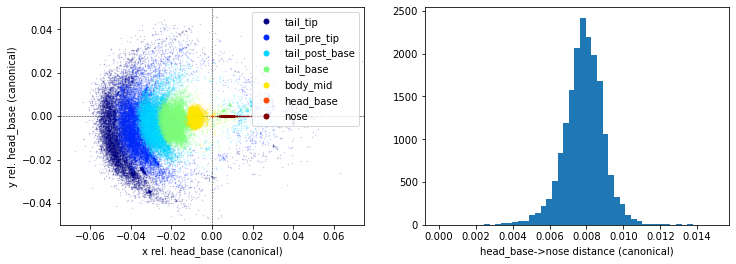

In [300]:
%matplotlib inline
fig,ax = plt.subplots(1,2,figsize=(12,4))

col = plt.cm.jet(np.linspace(0,1,7))
ax[0].axhline(0,color='k',linewidth=0.5,linestyle='--')
ax[0].axvline(0,color='k',linewidth=0.5,linestyle='--')
for i,o in enumerate(order):
    print(i,o,parts[i])
    ax[0].plot(px_rot[:,o],py_rot[:,o],'.',markersize=1,alpha=0.2,color=col[i])
    ax[0].plot(px_rot[0,o]+100,py_rot[0,o]+100,'.',markersize=10,alpha=1,color=col[i],label=parts[o])
ax[0].set_xlim([-0.075,0.075])
ax[0].set_ylim([-0.05,0.05])
ax[0].set_xlabel(f'x rel. {rot_parts[0]} (canonical)')
ax[0].set_ylabel(f'y rel. {rot_parts[0]} (canonical)')
ax[0].legend()

_ = ax[1].hist(px_rot[:,rotI[1]],bins=np.linspace(0,0.015,50))
ax[1].set_xlabel(f'{rot_parts[0]}->{rot_parts[1]} distance (canonical)')

fig.savefig('pose_stats.pdf')


## Random sampling

*Thinking out loud*: One way to sample would be to randomly mix pose points from all of the pose samples. However, this would inevitably lead to a strange mixture of pose relations that would not necessarily represent real poses.

*Some alternatives (from easiest to hardest)*:
- ignore most of the pose and only sample from "body_mid" distribution for ITOR bootstrap -- this would simplify ITOR calculation anyway and we don't have to worry about "realistic pose" because it is not contingent on chaining multiple parts together in a realistic way
- sample directly from all pose points (maybe excluding the current episode to avoid repeats) -- this would guarantee realistic poses
- learn some high dimensional pose space (ie. relationships between the parts, maybe via PCA) and create poses using weighted combinations of PCs plus noise?


In [314]:
# for now, sample the body-mid distribution at each timepoint in an episode
pt = e.episodes[14].trajectories.where('agent_name','prey').get_unique_steps()
step = pt[0]
pose = get_pose(step)
pose

{'body_mid': [0.0170635, 0.4995721249999999],
 'head_base': [0.0170635, 0.4995721249999999],
 'nose': [0.0170635, 0.4995721249999999],
 'tail_base': [0.0170635, 0.4995721249999999],
 'tail_post_base': [0.0170635, 0.4995721249999999],
 'tail_pre_tip': [0.0170635, 0.4995721249999999],
 'tail_tip': [0.0170635, 0.4995721249999999]}